<a href="https://colab.research.google.com/github/chuery/israelpalestinenews/blob/main/israelpaletinenews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob  # for simple sentiment analysis
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [ ]:
nyt_df = pd.read_csv("headlines_sorted-2.csv")
guardian_df = pd.read_csv("guardian_headlines_sorted.csv")

In [ ]:
nyt_df

,Unnamed: 0,Date,Headline
0,0,2023-10-01 09:00:32+00:00,The Deadly Red Tape of Israel’s Occupation in ...
1,1,2023-10-03 04:01:22+00:00,"Israeli Herders Spread Across West Bank, Displ..."
2,2,2023-10-03 23:00:08+00:00,How Four Leaders Are Turning the World Upside ...
3,3,2023-10-04 21:24:05+00:00,Democrats Tell Biden Saudi-Israel Pact Needs C...
4,4,2023-10-07 09:02:49+00:00,The war could upend Biden’s diplomacy on Saudi...
...,...,...,...
4252,4252,2025-02-28 10:02:39+00:00,How an Anguished Mother Became Netanyahu’s Fie...
4253,4253,2025-02-28 10:32:41+00:00,West Bank Operation Tests Palestinian Leaders’...
4254,4254,2025-02-28 14:39:54+00:00,What’s Next for the Gaza Truce? Look at the Bo...
4255,4255,2025-02-28 19:51:16+00:00,Jury Convicts Landlord in Fatal Stabbing of Pa...


In [ ]:
guardian_df

,Unnamed: 0,Date,Headline
0,0,2023-10-04 18:04:03+00:00,Gaza Strip protesters received bullet wounds t...
1,1,2023-10-05 08:42:01+00:00,Call for Labour government can transform Israe...
2,2,2023-10-07 10:49:58+00:00,Israel and Hamas at war after surprise attacks...
3,3,2023-10-07 13:16:28+00:00,Hamas’s stealth attack will be remembered as I...
4,4,2023-10-07 15:19:16+00:00,Condemnation and calls for restraint after Ham...
...,...,...,...
5008,5008,2025-02-28 12:51:50+00:00,Culture secretary to hold urgent meeting with ...
5009,5009,2025-02-28 14:35:22+00:00,‘He looks half the man he was’: brother of Isr...
5010,5010,2025-02-28 18:19:39+00:00,Israel proposes Gaza plan that gives it tighte...
5011,5011,2025-02-28 18:38:47+00:00,Anneliese Dodds resigns over Keir Starmer’s de...


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


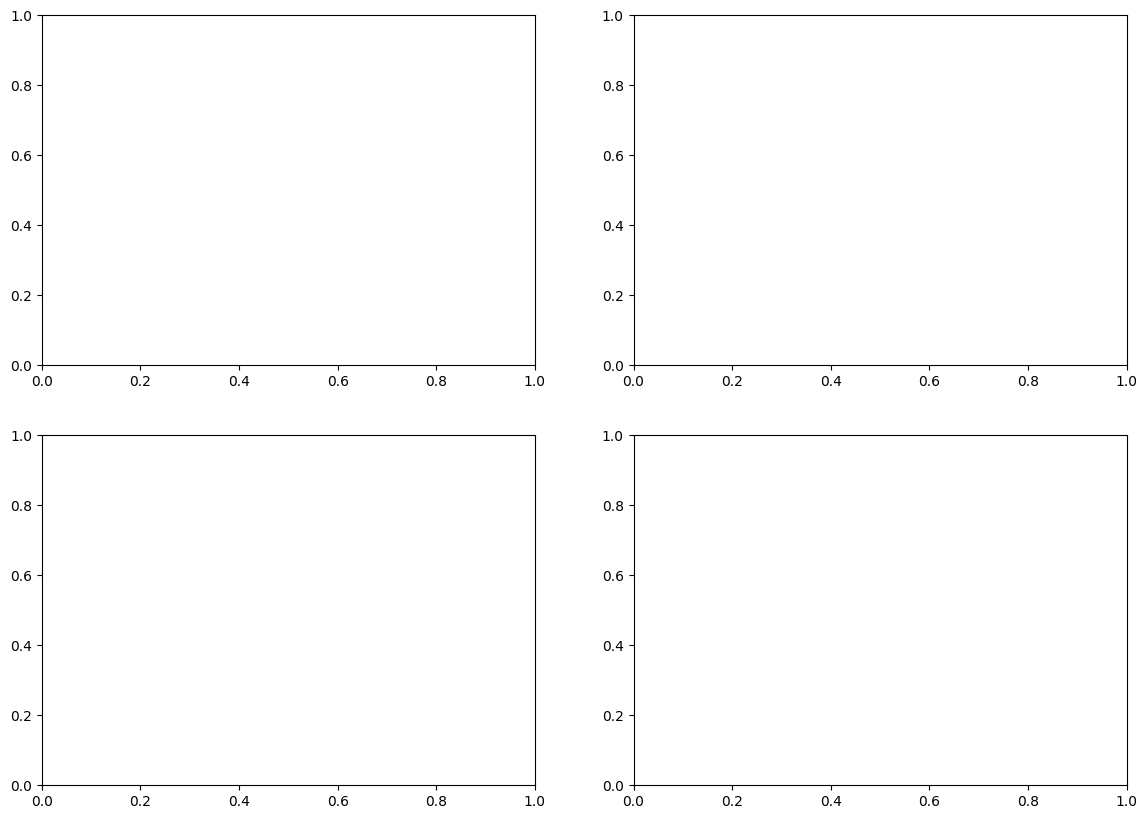

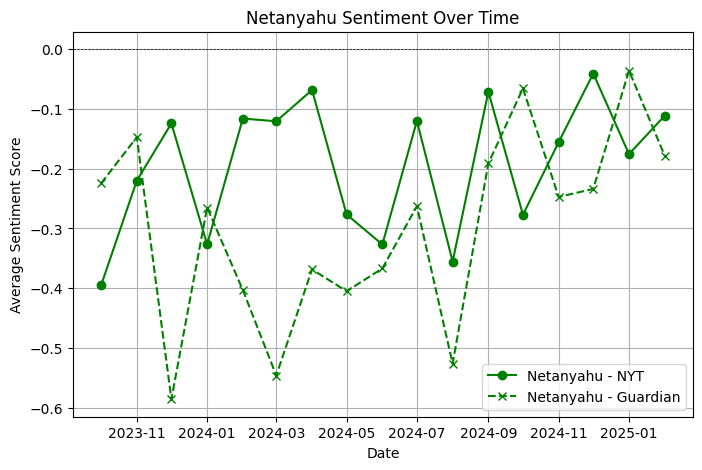

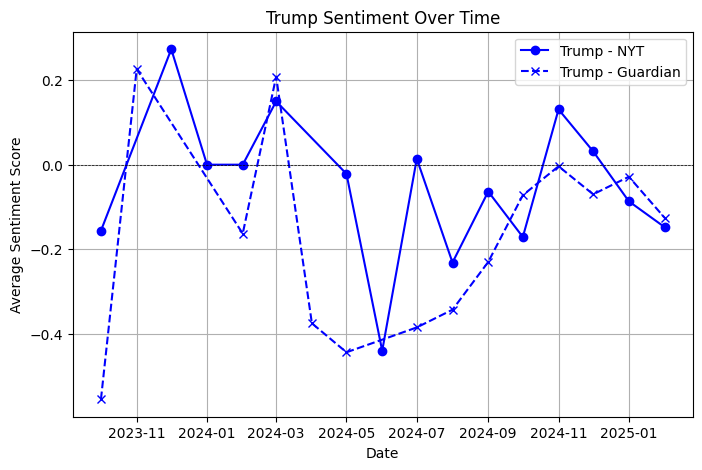

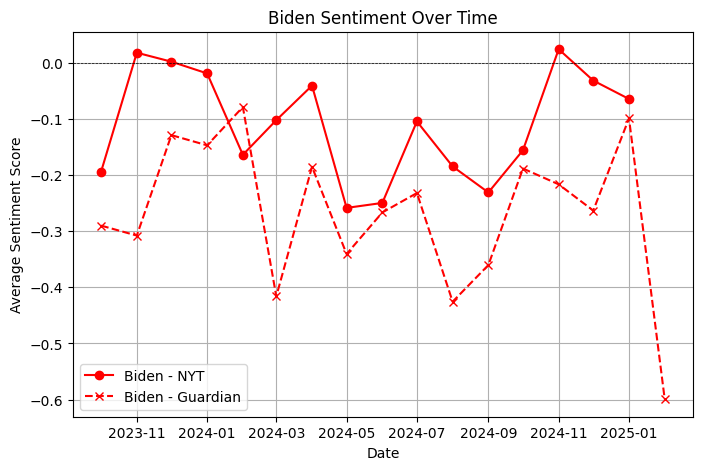

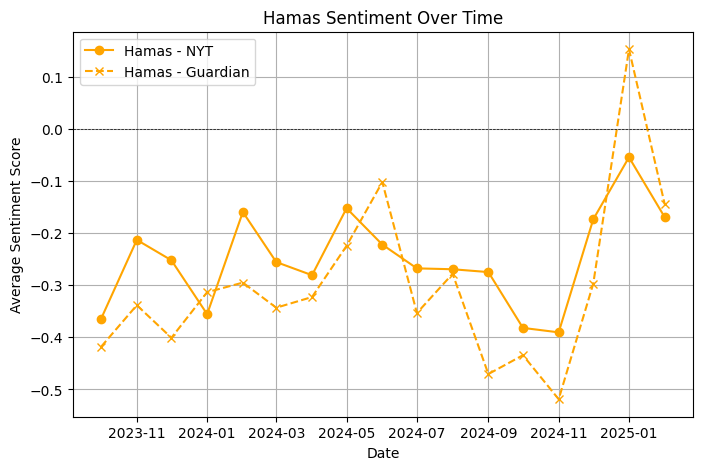

In [ ]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(headline):
    return sia.polarity_scores(str(headline))["compound"]  # Ensures input is a string

# Function to check if a headline mentions any specific keywords
def mentions_person_or_group(headline, keywords):
    headline_lower = str(headline).lower()  # Ensures input is a string
    return any(keyword in headline_lower for keyword in keywords)

# Define keywords for each entity
keywords_dict = {
    "Netanyahu": ['netanyahu'],
    "Trump": ['trump'],
    "Biden": ['biden'],
    "Hamas": ['hamas']
}

# Function to process each dataset
def process_data(df):
    df = df.copy()  # Avoid modifying original DataFrame
    df["Date"] = pd.to_datetime(df["Date"])  # Ensure datetime format

    processed_data = {}

    for person, keywords in keywords_dict.items():
        # Identify mentions
        df.loc[:, person + "_Mentions"] = df["Headline"].apply(lambda x: mentions_person_or_group(x, keywords))

        # Filter only relevant rows
        filtered_df = df[df[person + "_Mentions"]].copy()
        filtered_df["Date"] = filtered_df["Date"].dt.tz_localize(None)  # Remove timezone
        filtered_df.loc[:, "Month"] = filtered_df["Date"].dt.to_period("M")  # Convert to period

        # Apply sentiment analysis
        filtered_df.loc[:, person + "_Sentiment"] = filtered_df["Headline"].apply(get_sentiment_score)

        # Resample sentiment by month
        filtered_df.loc[:, 'Month'] = filtered_df["Date"].dt.to_period('M')
        average_sentiment_by_month = filtered_df.groupby('Month')[person + "_Sentiment"].mean()

        # Convert PeriodIndex to datetime
        average_sentiment_by_month.index = average_sentiment_by_month.index.to_timestamp()

        # Store results
        processed_data[person] = average_sentiment_by_month

    return processed_data

# Load and process data

nyt_processed_data = process_data(nyt_df)
guardian_processed_data = process_data(guardian_df)

# Create subplots (2x2 for four entities)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors and entities
persons = ['Netanyahu', 'Trump', 'Biden', 'Hamas']
colors = ['green', 'blue', 'red', 'orange']

# Create individual plots and save them
for i, person in enumerate(persons):
    plt.figure(figsize=(8, 5))  # Set figure size

    # NYT sentiment
    if not nyt_processed_data[person].empty:
        plt.plot(nyt_processed_data[person].index, nyt_processed_data[person],
                 label=f'{person} - NYT', color=colors[i], linestyle='-', marker='o')

    # Guardian sentiment
    if not guardian_processed_data[person].empty:
        plt.plot(guardian_processed_data[person].index, guardian_processed_data[person],
                 label=f'{person} - Guardian', color=colors[i], linestyle='--', marker='x')

    # Labels and formatting
    plt.title(f'{person} Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  # Neutral sentiment line
    plt.legend()
    plt.grid(True)

    # Save the figure in high quality
    plt.savefig(f'sentiment_{person}.png', dpi=300, bbox_inches='tight')

   # plt.close()  # Close the figure to free up memory

In [ ]:
import datetime
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(headline):
    return sia.polarity_scores(str(headline))["compound"]  # Ensures input is a string

# Function to check if a headline mentions any specific keywords
def mentions_person_or_group(headline, keywords):
    headline_lower = str(headline).lower()  # Ensures input is a string
    return any(keyword in headline_lower for keyword in keywords)

# Define keywords for each entity
keywords_dict = {
    "Netanyahu": ['netanyahu'],
    "Trump": ['trump'],
    "Biden": ['biden'],
    "Hamas": ['hamas']
}

# Function to process each dataset
def process_data(df):
    df = df.copy()  # Avoid modifying original DataFrame
    df["Date"] = pd.to_datetime(df["Date"])  # Ensure datetime format

    for person, keywords in keywords_dict.items():
        # Identify mentions
        df.loc[:, person + "_Mentions"] = df["Headline"].apply(lambda x: mentions_person_or_group(x, keywords))

    return df  # Return the modified DataFrame


# Load and process data
nyt_df = pd.read_csv("headlines_sorted-2.csv")
guardian_df = pd.read_csv("guardian_headlines_sorted.csv")

# Process the dataframes to add the _Mentions columns
nyt_df = process_data(nyt_df)
guardian_df = process_data(guardian_df)

# Filter for headlines mentioning Netanyahu between Feb 2024 and May 2024
start_date = datetime.date(2024, 2, 1)
end_date = datetime.date(2024, 5, 31)

nyt_biden_df = nyt_df[nyt_df["Biden_Mentions"]].copy()
nyt_biden_df["Date"] = pd.to_datetime(nyt_biden_df["Date"])

guardian_biden_df = guardian_df[guardian_df["Biden_Mentions"]].copy() # Create and filter guardian_biden_df
guardian_biden_df["Date"] = pd.to_datetime(guardian_biden_df["Date"])

# Convert start_date and end_date to Timestamp objects with UTC timezone
start_date = pd.Timestamp(start_date).tz_localize('UTC')
end_date = pd.Timestamp(end_date).tz_localize('UTC')

# Now the comparison should work correctly
nyt_biden_df = nyt_biden_df[(nyt_biden_df["Date"] >= start_date) & (nyt_biden_df["Date"] <= end_date)]
guardian_biden_df = guardian_biden_df[(guardian_biden_df["Date"] >= start_date) & (guardian_biden_df["Date"] <= end_date)] # Filter guardian_biden_df by date


# Calculate sentiment scores for the filtered headlines
nyt_biden_df["Sentiment"] = nyt_biden_df["Headline"].apply(get_sentiment_score)
guardian_biden_df["Sentiment"] = guardian_biden_df["Headline"].apply(get_sentiment_score)


# Print headlines and their sentiment scores
print("NYT Headlines about Biden (Feb 2024 - May 2024):")
for index, row in nyt_biden_df.iterrows():
    print(f"Headline: {row['Headline']}, Sentiment: {row['Sentiment']}")

print("\nGuardian Headlines about Biden (Feb 2024 - May 2024):")
for index, row in guardian_biden_df.iterrows():
    print(f"Headline: {row['Headline']}, Sentiment: {row['Sentiment']}")

NYT Headlines about Biden (Feb 2024 - May 2024):
Headline: Why Biden Is Losing Support Among Some Religious Black Voters, Sentiment: 0.0258
Headline: Biden sharpens criticism of Israel, calling its Gaza response ‘over the top.’, Sentiment: -0.4404
Headline: Biden Cautions Netanyahu on Ground Offensive in Southern Gaza, Sentiment: -0.4588
Headline: Biden and Jordan’s King Call on Israel to Protect Palestinians in Rafah, Sentiment: 0.3818
Headline: Only Biden and M.B.S. Can Redirect the Israeli-Palestinian Conflict, Sentiment: -0.3182
Headline: Biden Shields Palestinians in the U.S. From Deportation, Sentiment: 0.0
Headline: Biden Tried to Show Solidarity With East Palestine. He Found Divisions Instead., Sentiment: 0.296
Headline: Protesting Biden, Gaza Supporters Warn, ‘Don’t Blame Us’ if You Lose, Sentiment: -0.6597
Headline: Will Biden’s Gaza Stance Hurt Him in 2024? Michigan Is the First Test., Sentiment: -0.5267
Headline: Your Questions on Open Conventions, a Gaza Schism and Biden’s

In [ ]:
def remove_keywords(text):
    keywords = ["Palestine", "Israel Palestine", "Palestinians", "Israel", "IDF", "Hamas", "Gaza",]
    for word in keywords:
        text = text.replace(word, "")
    return " ".join(text.split())  # Remove extra spaces

nyt_df["Headline"] = nyt_df["Headline"].apply(remove_keywords)
guardian_df["Headline"] = guardian_df["Headline"].apply(remove_keywords)


In [ ]:
import nltk
# Download required NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define custom tokenizer function
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenization & lowercasing
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  # Lemmatization & remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing before vectorization
nyt_df["cleaned_Headline"] = nyt_df["Headline"].apply(preprocess)
guardian_df["cleaned_Headline"] = guardian_df["Headline"].apply(preprocess) # Added the preprocess function call here

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# --- NYT --- #
vec_nyt = TfidfVectorizer()
tfidf_nyt = vec_nyt.fit_transform(nyt_df["cleaned_Headline"])
model_nyt = KMeans(n_clusters=7, random_state=42)
model_nyt.fit(tfidf_nyt)
nyt_df["cluster"] = model_nyt.predict(tfidf_nyt)

# --- Guardian --- #
vec_guardian = TfidfVectorizer()
tfidf_guardian = vec_guardian.fit_transform(guardian_df["cleaned_Headline"])
model_guardian = KMeans(n_clusters=7, random_state=42)
model_guardian.fit(tfidf_guardian)
guardian_df["cluster"] = model_guardian.predict(tfidf_guardian)

# --- Get top words for each cluster for NYT --- #
feature_names_nyt = vec_nyt.get_feature_names_out()  # Get feature names for NYT
centroids_nyt = model_nyt.cluster_centers_        # Get centroids for NYT
top_n = 20

# --- Get top words for each cluster for Guardian --- #
feature_names_guardian = vec_guardian.get_feature_names_out()  # Get feature names for Guardian
centroids_guardian = model_guardian.cluster_centers_        # Get centroids for Guardian


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

clusters_nyt = nyt_df['cluster'].unique()

for cluster in clusters_nyt:
    # Create a new figure for each word cloud
    plt.figure(figsize=(10, 5), dpi=300)  # High-quality resolution (300 dpi)

    # Use 'cleaned_Headline' directly, NO re-preprocessing
    cluster_text = " ".join(nyt_df[nyt_df['cluster'] == cluster]['cleaned_Headline'].astype(str))

    word_freq = Counter(cluster_text.split())  # Count word frequencies

    # Remove unwanted words based on clusters
    if cluster == 2:
        word_freq.pop('ha', None)  # Use .pop() to avoid KeyError if word isn't present

    if cluster in {0, 3, 6}:
        word_freq.pop('u', None)

    # Generate word cloud
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(word_freq)

    # Display word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"nyt Cluster {cluster}", fontsize=14)

    # Save the word cloud image with high resolution
    filename = f"wordcloud_cluster_nyt_{cluster}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Ensures high-quality and no extra whitespace

    plt.close()  # Close the figure to free memory

print("Word clouds saved successfully!")


Word clouds saved successfully!


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

clusters_guardian = guardian_df['cluster'].unique()

for cluster in clusters_guardian:
    # Create a new figure for each word cloud
    plt.figure(figsize=(10, 5), dpi=300)  # High-quality resolution (300 dpi)

    # Use 'cleaned_Headline' directly, NO re-preprocessing
    cluster_text = " ".join(guardian_df[guardian_df['cluster'] == cluster]['cleaned_Headline'].astype(str))

    word_freq = Counter(cluster_text.split())  # Count word frequencies

    # Remove unwanted words based on clusters
    if cluster == 2:
        word_freq.pop('ha', None)  # Use .pop() to avoid KeyError if word isn't present

    if cluster in {0, 3, 6}:
        word_freq.pop('u', None)

    # Generate word cloud
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(word_freq)

    # Display word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Guardian Cluster {cluster}", fontsize=14)

    # Save the word cloud image with high resolution
    filename = f"wordcloud_cluster_guardian_{cluster}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Ensures high-quality and no extra whitespace

    plt.close()  # Close the figure to free memory


In [ ]:
# ... (Your existing code for preprocessing, vectorization, clustering) ...

# Print headlines per cluster
for cluster_num in range(7):  # Assuming 7 clusters
    cluster_headlines = nyt_df[nyt_df["cluster"] == cluster_num]
    print(f"Cluster {cluster_num}:")
    for i in range(min(30, len(cluster_headlines))):  # Print up to 30 headlines
        print(cluster_headlines.iloc[i]['Headline'])  # Access headline using iloc
    print("-" * 30)  # Separator between clusters

Cluster 0:
Humanitarian Aid Continues to Amass at Egypt’s Border as Crisis in Worsens
U.S. Says Didn’t Cause Hospital Blast, as Biden Promises Aid to
Deal Lays Groundwork for Aid to Reach Desperate ns, Officials Say
The U.N. Brokered a Deal to Bring Aid Into
A Deal for Aid Into , and More
Promised Aid to Is Stalled by Wrangling, as Conditions Worsen
First Convoy of Aid Enters Through Rafah Crossing
First Humanitarian Aid Reaches a Hard-Pressed
Intensifies Strikes on as Its Allies Call for More Palestinian Aid
With Fuel Scarce, U.N. Aid Group in Desperate May Scale Back
What to Know About UNRWA, the Largest Aid Organization in
i Tanks Raid Ahead of Invasion, While Aid Trickles In
The Battle Over Aid to
Saudi Arabia Begins Aid Effort for and Raises $17 Million in Hours
U.S. Drones Are Flying Over to Aid in Hostage Recovery, Officials Say
Jordan Airdrops Medical Aid to Its Field Hospital in
Senate Democrats Challenge Biden on , Seeking Assurances About Aid
Blinken Stresses Need for Humani

In [ ]:
# ... (Your existing code for preprocessing, vectorization, clustering) ...

# Print headlines per cluster
for cluster_num in range(7):  # Assuming 7 clusters
    cluster_headlines = guardian_df[guardian_df["cluster"] == cluster_num]
    print(f"Cluster {cluster_num}:")
    for i in range(min(30, len(cluster_headlines))):  # Print up to 30 headlines
        print(cluster_headlines.iloc[i]['Headline'])  # Access headline using iloc
    print("-" * 30)  # Separator between clusters

Cluster 0:
EU aid to will ‘not be cancelled’ as decision reversed
US holds talks on aid corridor as continues airstrikes
Forget the lie about EU money for . For ordinary , the aid is a lifeline | Martin Konečný
Biden draws direct link between Putin and as he urges aid for and Ukraine
intensifies attacks on north as WFP says more aid urgently needed
Mitch McConnell backs Biden’s $106bn aid request for and Ukraine
- war: second convoy of as 14 aid trucks enters – as it happened
EU foreign ministers back humanitarian pause in - war to let in aid
UN warns aid operation will soon stop if fuel not let in
i forces advance in northern , as aid trickles in from the south
targets tunnels amid hopes more aid will reach civilians in
WHO says ‘almost impossible’ to bring aid into – as it happened
Leftist Democrats invoke human rights law in scrutiny of military aid
- war is deadliest ever for UN aid workers, with at least 88 killed
Aid charities urge Rishi Sunak to condemn ’s siege in
Democrats sup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


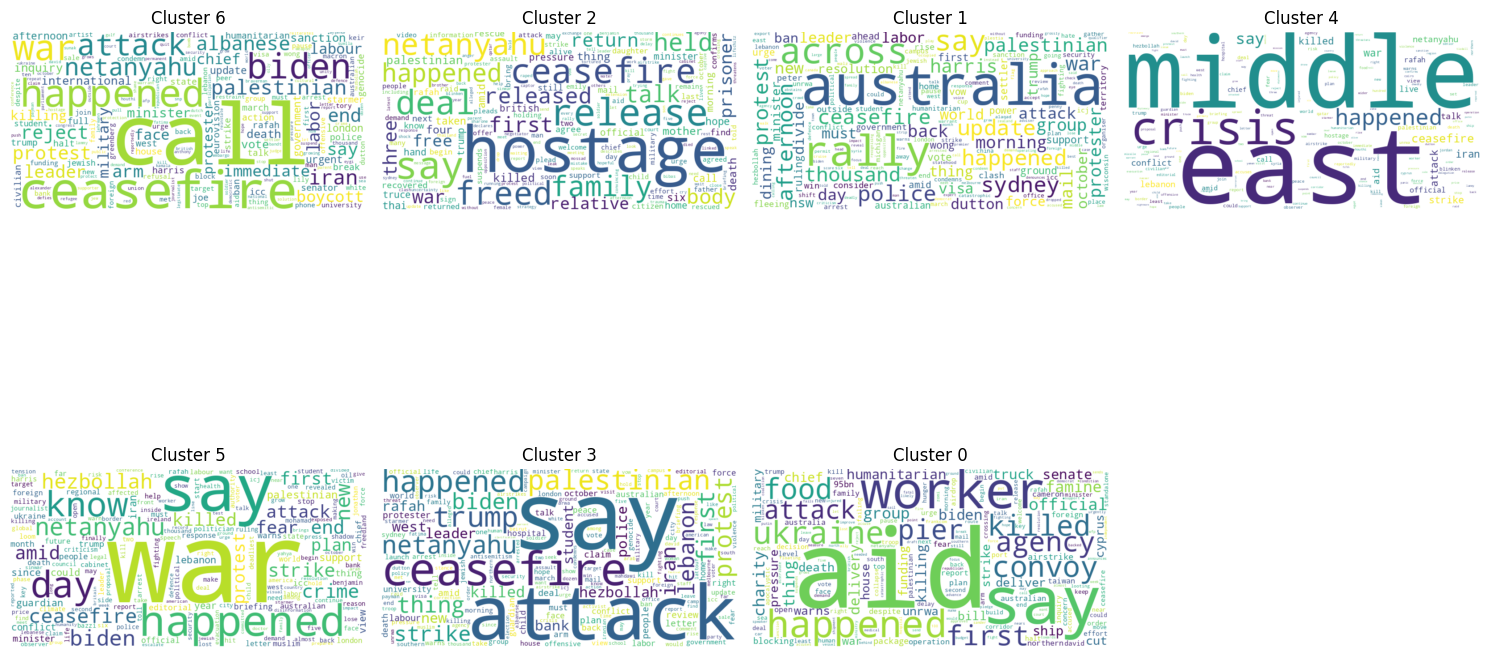

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK stopwords if needed
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with actual file path)
# Expected format: a CSV with 'headline' and 'cluster' columns

# Function to clean and tokenize text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and len(word) > 2] # Remove "ha"
    tokens = [word for word in tokens if word not in stop_words]
    return tokens  # Return tokens instead of joined string

# Create word clouds for each cluster
guardian_clusters = guardian_df['cluster'].unique()
plt.figure(figsize=(15, 10))

for i, cluster in enumerate(clusters, 1):
    plt.subplot(2, (len(clusters) + 1) // 2, i)  # Adjust grid size dynamically
    cluster_text = " ".join(guardian_df[guardian_df['cluster'] == cluster]['cleaned_Headline'])
    words = preprocess_text(cluster_text)

    # Remove 'ha' from the words list
    words = [word for word in words if word != 'ha']

    word_freq = Counter(words)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

['biden', 'middle', 'east', 'war', 'say', 'netanyahu', 'policy', 'support', 'visit', 'attack', 'trump', 'call', 'joe', 'push', 'democrat', 'president', 'voter', 'condemns', 'deal', 'peace']


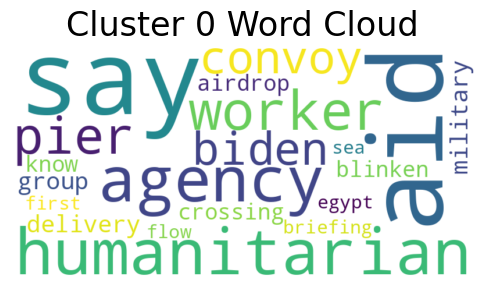

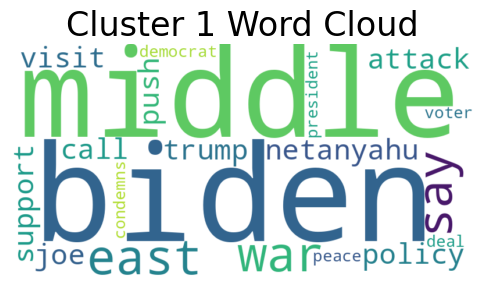

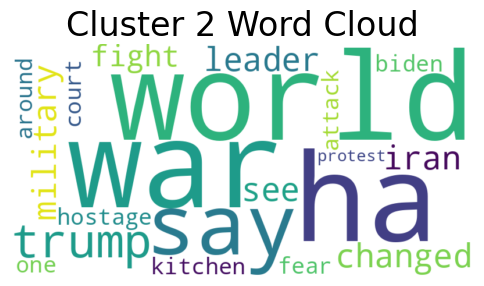

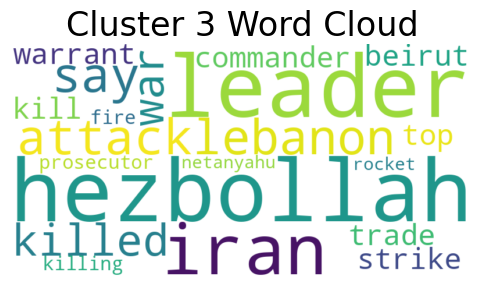

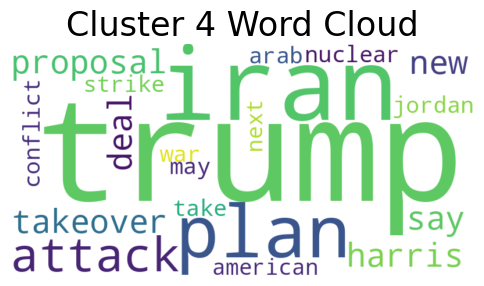

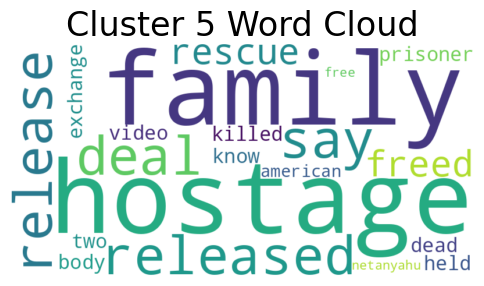

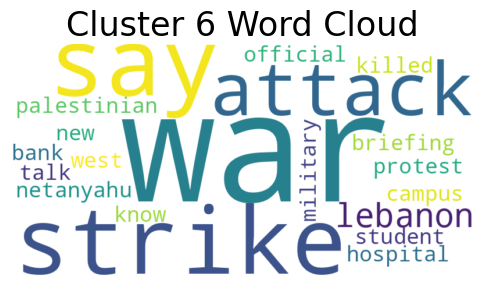

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cluster_top_words = {}

for i, centroid in enumerate(centroids):
    top_indices = centroid.argsort()[-top_n:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    cluster_top_words[i] = top_words  # Store in dictionary

# Example: Access top words for Cluster 0
print(cluster_top_words[1])

for cluster_id, top_words in cluster_top_words.items():  # Iterate over dictionary
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(top_words))

    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} Word Cloud")
    plt.show()

In [ ]:
# prompt: print out 20 most relevant headlines per cluster by what cluster they're in, include which cluster they're in

for cluster_num in range(7):  # Assuming 7 clusters
    cluster_headlines = nyt_df[nyt_df["cluster"] == cluster_num]
    print(f"Cluster {cluster_num}:")
    for i in range(min(30, len(cluster_headlines))): # Print up to 20 headlines per cluster
      print(cluster_headlines.iloc[i]['Headline'])
    print("-" * 30)


Cluster 0:
Humanitarian Aid Continues to Amass at Egypt’s Border as Crisis in Worsens
U.S. Says Didn’t Cause Hospital Blast, as Biden Promises Aid to
Deal Lays Groundwork for Aid to Reach Desperate ns, Officials Say
The U.N. Brokered a Deal to Bring Aid Into
A Deal for Aid Into , and More
Promised Aid to Is Stalled by Wrangling, as Conditions Worsen
First Convoy of Aid Enters Through Rafah Crossing
First Humanitarian Aid Reaches a Hard-Pressed
Intensifies Strikes on as Its Allies Call for More Palestinian Aid
With Fuel Scarce, U.N. Aid Group in Desperate May Scale Back
What to Know About UNRWA, the Largest Aid Organization in
i Tanks Raid Ahead of Invasion, While Aid Trickles In
The Battle Over Aid to
Saudi Arabia Begins Aid Effort for and Raises $17 Million in Hours
U.S. Drones Are Flying Over to Aid in Hostage Recovery, Officials Say
Jordan Airdrops Medical Aid to Its Field Hospital in
Senate Democrats Challenge Biden on , Seeking Assurances About Aid
Blinken Stresses Need for Humani

In [ ]:

# Create vectorizer with preprocessing
vec = TfidfVectorizer()
tfidf = vec.fit_transform(nyt_df["Headline"])

# Train KMeans model
model = KMeans(n_clusters=7, random_state=42)
model.fit(tfidf)

# Assign clusters
nyt_df["cluster"] = model.predict(tfidf)

# Get top words for each cluster
feature_names = vec.get_feature_names_out()
centroids = model.cluster_centers_
top_n = 20

# prompt: print out 20 most relevant headlines per cluster by what cluster they're in, include which cluster they're in

for cluster_num in range(7):  # Assuming 7 clusters
    cluster_headlines = nyt_df[nyt_df["cluster"] == cluster_num]
    print(f"Cluster {cluster_num}:")
    for i in range(min(30, len(cluster_headlines))): # Print up to 20 headlines per cluster
      print(cluster_headlines.iloc[i]['Headline'])
    print("-" * 30)


Cluster 0:
Gaza Has Suffered Under 16-Year Blockade
An Attack From Gaza and an Israeli Declaration of War. Now What?
Hospitals and Morgues in Gaza Are Crowded as People Seek Their Loved Ones
‘Everyone Was Surprised’: Palestinians in Gaza React to Conflict
Israeli Airstrikes Hit Marketplace and Mosques in Gaza, Killing Dozens
Tuesday Briefing: Israel Orders a ‘Siege’ of Gaza
Zelensky Says Gaza War Furthers Russian Aims
Nowhere to Hide in Gaza as Israeli Onslaught Continues
Israel Regains Control of Border Villages as War Intensifies in Gaza
Israel Could Be Walking Into a Trap in Gaza
Gaza Braces for First Ground Invasion in Years, and More
Rescuers in Gaza Struggle With Dwindling Fuel and Lack of Equipment
Seeking a Moral Compass in Gaza’s War
This Hospital in Gaza Is Running Short on Fuel and Beds
As Israel Prepares for War in Gaza, Debate Is Over How and How Long
Israel Prepares for a Potential Invasion of Gaza
Gaza Hospital Inundated With Wounded Patients
Humanitarian Crisis in Gaza 

In [ ]:
nyt_df

,Unnamed: 0,Date,Headline,cleaned_Headline
0,0,2023-10-01 09:00:32+00:00,The Deadly Red Tape of Israel’s Occupation in ...,deadly red tape israel occupation palestine
1,1,2023-10-03 04:01:22+00:00,"Israeli Herders Spread Across West Bank, Displ...",israeli herder spread across west bank displac...
2,2,2023-10-03 23:00:08+00:00,How Four Leaders Are Turning the World Upside ...,four leader turning world upside
3,3,2023-10-04 21:24:05+00:00,Democrats Tell Biden Saudi-Israel Pact Needs C...,democrat tell biden pact need concession pales...
4,4,2023-10-07 09:02:49+00:00,The war could upend Biden’s diplomacy on Saudi...,war could upend biden diplomacy normalization
...,...,...,...,...
4252,4252,2025-02-28 10:02:39+00:00,How an Anguished Mother Became Netanyahu’s Fie...,anguished mother became netanyahu fiercest foe
4253,4253,2025-02-28 10:32:41+00:00,West Bank Operation Tests Palestinian Leaders’...,west bank operation test palestinian leader ab...
4254,4254,2025-02-28 14:39:54+00:00,What’s Next for the Gaza Truce? Look at the Bo...,next gaza truce look border egypt
4255,4255,2025-02-28 19:51:16+00:00,Jury Convicts Landlord in Fatal Stabbing of Pa...,jury convict landlord fatal stabbing palestini...


<Figure size 1200x600 with 0 Axes>

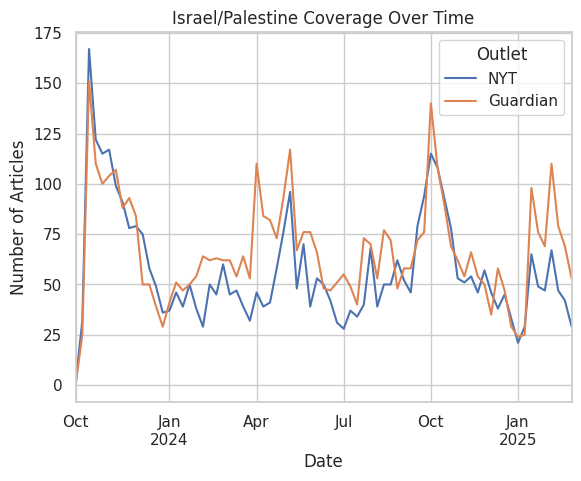

In [ ]:
# Ensure date column is in datetime format
nyt_df['Date'] = pd.to_datetime(nyt_df['Date'])
guardian_df['Date'] = pd.to_datetime(guardian_df['Date'])

# Resample by week (or 'M' for month if you prefer)
nyt_weekly = nyt_df.resample('W', on='Date').count()['Headline'].rename('NYT')
guardian_weekly = guardian_df.resample('W', on='Date').count()['Headline'].rename('Guardian')

# Combine into one DataFrame
coverage_df = pd.concat([nyt_weekly, guardian_weekly], axis=1).fillna(0)

# Plot
plt.figure(figsize=(12,6))
coverage_df.plot(kind='line')
plt.title('Israel/Palestine Coverage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(title='Outlet')
plt.show()


In [ ]:
themes = {
    'Hostages': ['hostage', 'kidnap', 'captivity'],
    'Humanitarian Crisis': ['humanitarian', 'aid', 'crisis', 'gaza', 'blockade', 'refugee', 'hunger', 'water', 'medical'],
    'Iran and Regional Actors': ['iran', 'hezbollah', 'lebanon', 'houthi', 'axis of resistance'],
    'Hamas Attacks and Terror': ['hamas', 'attack', 'terror', 'massacre', 'militant', 'rocket', 'assault'],
    'Israel\'s Government & Military': ['netanyahu', 'idf', 'defense', 'israel army', 'settlement', 'occupation', 'government', 'cabinet'],
    'Ceasefire & Negotiations': ['ceasefire', 'truce', 'negotiation', 'deal', 'peace', 'talks'],
    'Diplomacy & International Response': ['biden', 'us', 'un', 'america', 'blinken', 'white house', 'international', 'sanctions', 'eu'],
    'Protests & Public Opinion': ['protest', 'march', 'demonstration', 'rally', 'solidarity', 'activists', 'public opinion'],
    'Geopolitics & Global Reactions': ['china', 'russia', 'ukraine', 'world', 'global', 'international community'],
}


In [ ]:
# Function for multi-labeling (returns a list of matched themes)
def assign_multiple_themes(headline):
    headline_lower = headline.lower()
    matched_themes = [theme for theme, keywords in themes.items() if any(keyword in headline_lower for keyword in keywords)]
    return matched_themes if matched_themes else ['Miscellaneous']

# Apply to datasets
nyt_df['Themes'] = nyt_df['Headline'].apply(assign_multiple_themes)
guardian_df['Themes'] = guardian_df['Headline'].apply(assign_multiple_themes)


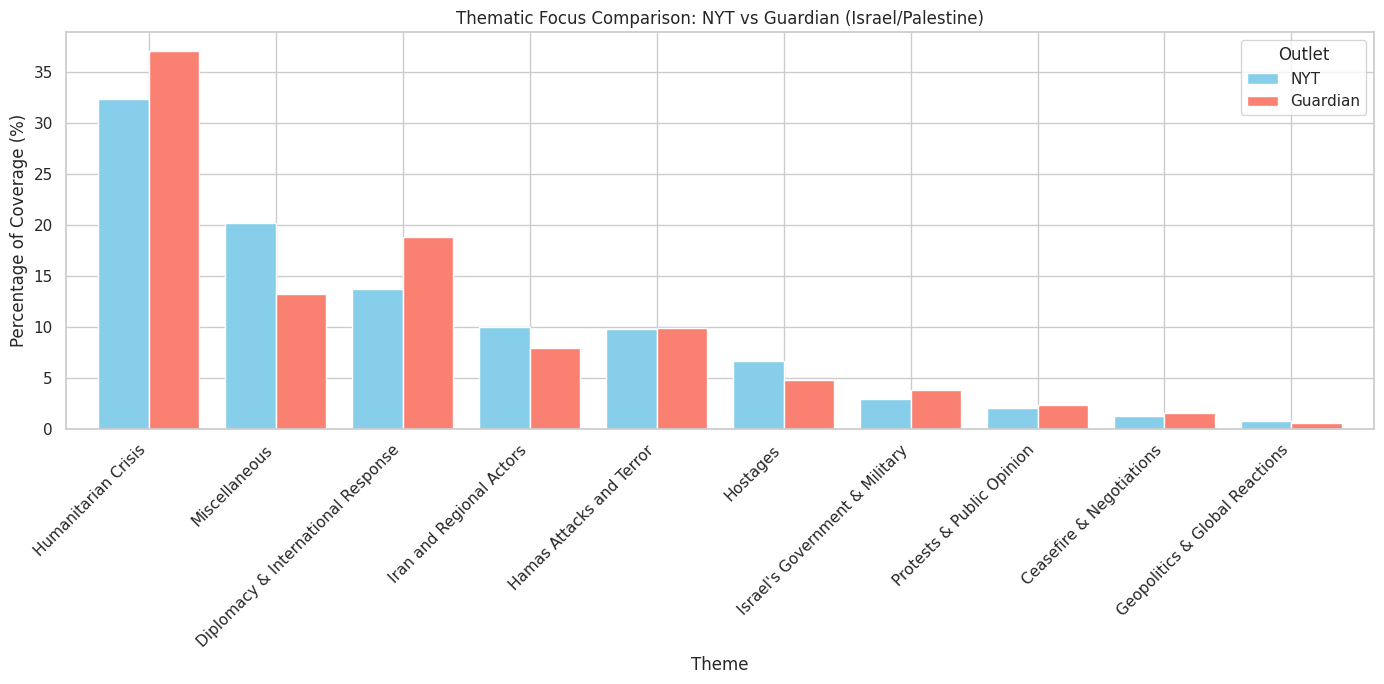

In [ ]:
# Count and normalize for % share
nyt_theme_counts = nyt_df['Theme'].value_counts(normalize=True).mul(100).round(1)
guardian_theme_counts = guardian_df['Theme'].value_counts(normalize=True).mul(100).round(1)

# Combine into comparison DataFrame
theme_compare_df = pd.DataFrame({'NYT': nyt_theme_counts, 'Guardian': guardian_theme_counts}).fillna(0)

# Sort themes for better visualization (optional)
theme_compare_df = theme_compare_df.sort_values(by='NYT', ascending=False)

# Plot side-by-side bar chart
theme_compare_df.plot(kind='bar', figsize=(14,7), rot=45, width=0.8, color=['skyblue', 'salmon'])
plt.ylabel('Percentage of Coverage (%)')
plt.title('Thematic Focus Comparison: NYT vs Guardian (Israel/Palestine)')
plt.legend(title='Outlet')
plt.xticks(rotation=45, ha='right') # Rotate and align labels
plt.tight_layout()
plt.show()


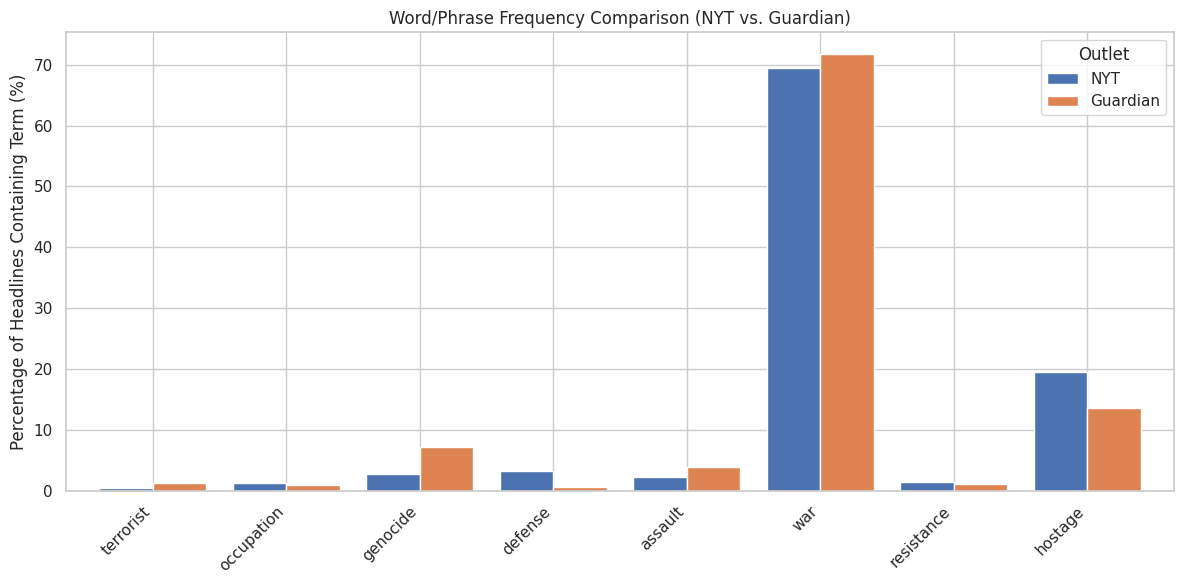

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define key framing terms to analyze
keywords = ['terrorist', 'occupation', 'genocide', 'defense', 'assault', 'war', 'resistance', 'hostage']

# Sample DataFrames
# nyt_df and guardian_df should already be defined with 'Headline' column

def count_keywords(df, keywords):
    counts = {}
    for word in keywords:
        # Count how many headlines contain the word (case-insensitive)
        counts[word] = df['Headline'].str.contains(fr'\b{word}\b', case=False, regex=True).sum()
    return counts

# Count occurrences
nyt_counts = count_keywords(nyt_df, keywords)
guardian_counts = count_keywords(guardian_df, keywords)

# Combine into one DataFrame
freq_df = pd.DataFrame([nyt_counts, guardian_counts], index=['NYT', 'Guardian']).T

# Normalize to percentage if needed
freq_df_percent = freq_df.div(freq_df.sum(axis=0), axis=1) * 100

# Plot
freq_df_percent.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Word/Phrase Frequency Comparison (NYT vs. Guardian)')
plt.ylabel('Percentage of Headlines Containing Term (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Outlet')
plt.tight_layout()
plt.show()


In [ ]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


<ipython-input-24-1bf3669bd921>:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  nyt_df.groupby(nyt_df['Date'].dt.to_period('2W'))['Sentiment'].mean().plot(label='NYT')
<ipython-input-24-1bf3669bd921>:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  guardian_df.groupby(guardian_df['Date'].dt.to_period('2W'))['Sentiment'].mean().plot(label='Guardian')


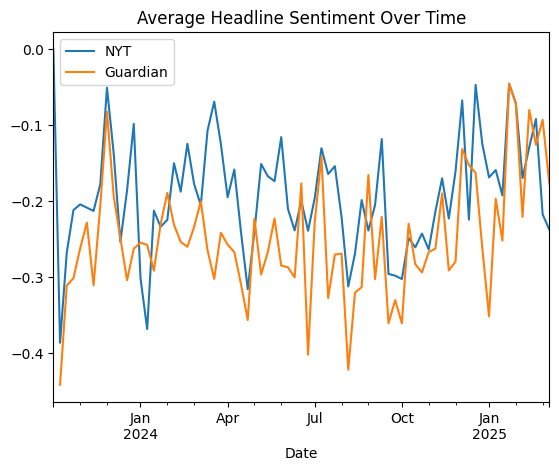

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nyt_df['Date'] = pd.to_datetime(nyt_df['Date'])
guardian_df['Date'] = pd.to_datetime(guardian_df['Date'])

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(headline):
    score = analyzer.polarity_scores(headline)
    return score['compound']  # Compound score summarizes overall sentiment

nyt_df['Sentiment'] = nyt_df['Headline'].apply(get_sentiment)
guardian_df['Sentiment'] = guardian_df['Headline'].apply(get_sentiment)

# Example: Average sentiment over time
nyt_df.groupby(nyt_df['Date'].dt.to_period('2W'))['Sentiment'].mean().plot(label='NYT')
guardian_df.groupby(guardian_df['Date'].dt.to_period('2W'))['Sentiment'].mean().plot(label='Guardian')
plt.title('Average Headline Sentiment Over Time')
plt.legend()
plt.show()


USE CODE BELOW FOR POSTER

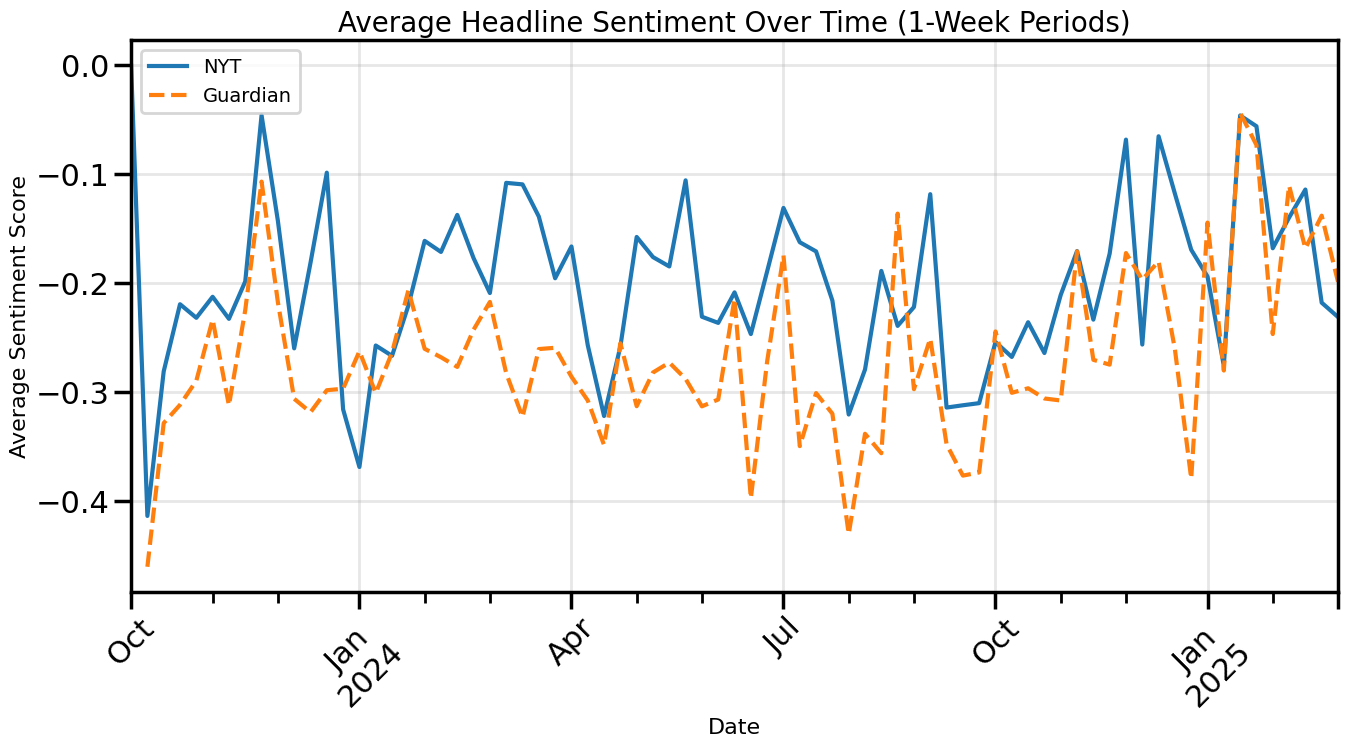

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load your data (assuming CSV files)
# df_nyt = pd.read_csv("nyt_headlines.csv")
# df_guardian = pd.read_csv("guardian_headlines.csv")

# Sample DataFrame structure for reference:
# df_nyt = pd.DataFrame({'Date': ['2024-03-01', '2024-03-02'], 'Headline': ['Great news today!', 'Bad weather ahead.']})
# df_guardian = pd.DataFrame({'Date': ['2024-03-01', '2024-03-02'], 'Headline': ['Stock market crashes', 'Sunny weekend!']})

### --- PREPROCESSING FUNCTION --- ###
def preprocess_headlines(df):
    """Cleans and prepares the data for sentiment analysis."""
    df = df.copy()  # Avoid modifying original DataFrame

    # Drop missing values
    df.dropna(subset=['Headline', 'Date'], inplace=True)

    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Convert text to lowercase
    df['Headline'] = df['Headline'].str.lower()

    # Remove special characters (optional, but can help)
    df['Headline'] = df['Headline'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

    # Drop duplicate headlines
    df.drop_duplicates(subset=['Headline'], inplace=True)

    return df

# Apply preprocessing
nyt_df = preprocess_headlines(nyt_df)
guardian_df = preprocess_headlines(guardian_df)

### --- SENTIMENT ANALYSIS --- ###
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(headline):
    """Returns VADER compound sentiment score."""
    return analyzer.polarity_scores(headline)['compound']

# Apply sentiment analysis
nyt_df['Sentiment'] = nyt_df['Headline'].apply(get_sentiment_score)
guardian_df['Sentiment'] = guardian_df['Headline'].apply(get_sentiment_score)

### --- GROUPING & PLOTTING --- ###
# Group by 2-week periods and compute average sentiment
nyt_sentiment_trend = nyt_df.groupby(pd.Grouper(key='Date', freq='W'))['Sentiment'].mean()
guardian_sentiment_trend = guardian_df.groupby(pd.Grouper(key='Date', freq='W'))['Sentiment'].mean()

# Plot the results
sns.set_context('poster')
plt.figure(figsize=(14, 8))  # Bigger figure for better readability
nyt_sentiment_trend.plot(label='NYT', linestyle='-')
guardian_sentiment_trend.plot(label='Guardian', linestyle='--')

# Formatting the plot
plt.title('Average Headline Sentiment Over Time (1-Week Periods)', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Sentiment Score', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)

# --- SAVE FIGURE --- #
plt.tight_layout()  # Prevent clipping of labels

# Construct a path within the current working directory or a designated output folder
output_dir = "output"  # Create a directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "sentiment_trend.png")

plt.savefig(output_path, dpi=300)
plt.show()

<ipython-input-39-c3caf7c9e85c>:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nyt_sentiment_trend = pd.merge(common_dates_df, nyt_grouped, on='Date', how='left').fillna(method='ffill')
<ipython-input-39-c3caf7c9e85c>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  guardian_sentiment_trend = pd.merge(common_dates_df, guardian_grouped, on='Date', how='left').fillna(method='ffill')


FileNotFoundError: [Errno 2] No such file or directory: '/root/Downloads/sentiment_trend.png'

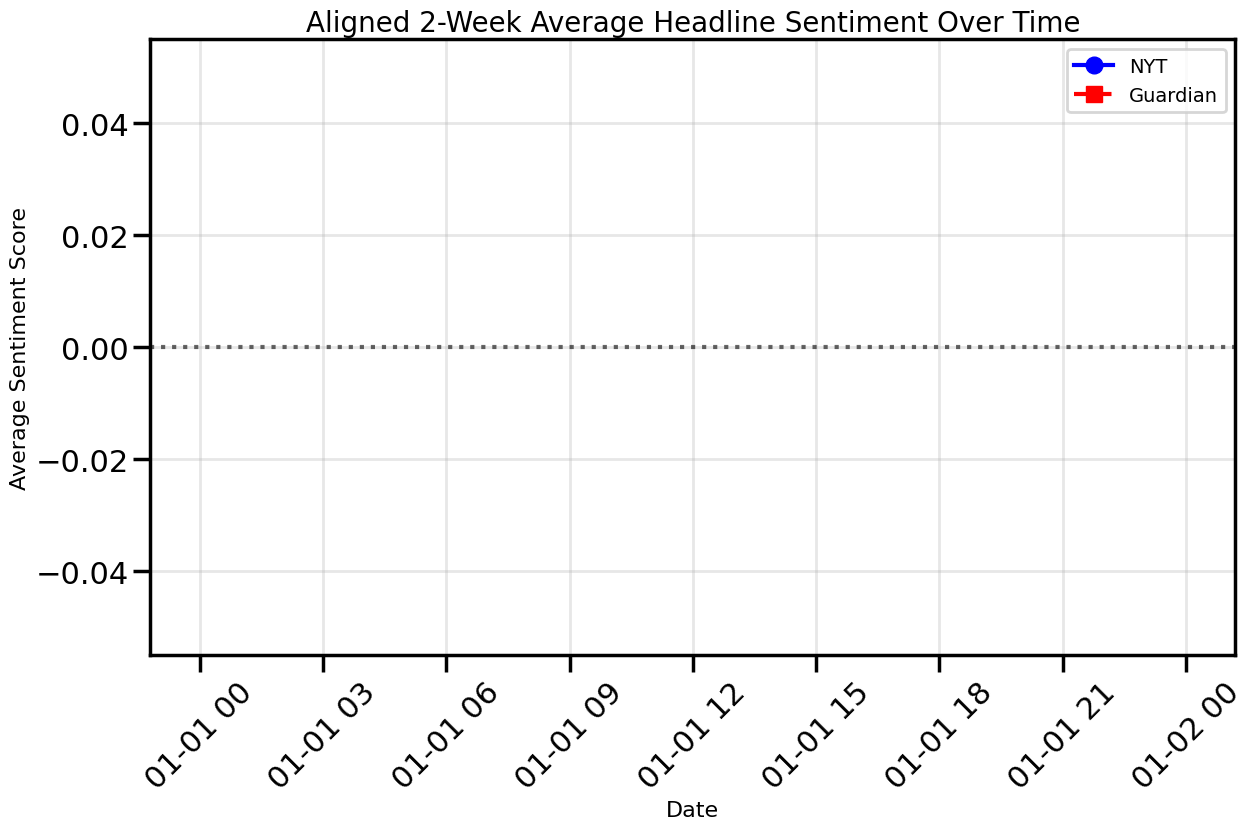

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- SENTIMENT ANALYSIS FUNCTION --- #
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(headline):
    return analyzer.polarity_scores(headline)['compound']

# --- PREPROCESSING FUNCTION --- #
def preprocess_headlines(df):
    df = df.copy()
    df.dropna(subset=['Headline', 'Date'], inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Ensure proper datetime
    df['Headline'] = df['Headline'].str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Clean text
    df.drop_duplicates(subset=['Headline'], inplace=True)  # Remove duplicate headlines
    return df

# --- LOAD & PREPROCESS DATA --- #
nyt_df = preprocess_headlines(nyt_df)
guardian_df = preprocess_headlines(guardian_df)

# Drop any remaining missing values
nyt_df = nyt_df.dropna(subset=['Date', 'Headline'])
guardian_df = guardian_df.dropna(subset=['Date', 'Headline'])

# --- APPLY SENTIMENT ANALYSIS --- #
nyt_df['Sentiment'] = nyt_df['Headline'].apply(get_sentiment_score)
guardian_df['Sentiment'] = guardian_df['Headline'].apply(get_sentiment_score)

# --- CREATE A COMMON DATE RANGE --- #
min_date = min(nyt_df['Date'].min(), guardian_df['Date'].min())
max_date = max(nyt_df['Date'].max(), guardian_df['Date'].max())

common_date_range = pd.date_range(start=min_date, end=max_date, freq='2W')

# --- GROUP SENTIMENT BY 2-WEEK PERIODS --- #
nyt_grouped = nyt_df.groupby(pd.Grouper(key='Date', freq='2W'))['Sentiment'].mean().reset_index()
guardian_grouped = guardian_df.groupby(pd.Grouper(key='Date', freq='2W'))['Sentiment'].mean().reset_index()

# --- MERGE WITH THE FULL DATE RANGE TO AVOID EMPTY PLOTS --- #
common_dates_df = pd.DataFrame({'Date': common_date_range})

nyt_sentiment_trend = pd.merge(common_dates_df, nyt_grouped, on='Date', how='left').fillna(method='ffill')
guardian_sentiment_trend = pd.merge(common_dates_df, guardian_grouped, on='Date', how='left').fillna(method='ffill')

# --- PLOTTING --- #
sns.set_context('poster')

plt.figure(figsize=(14, 8))
plt.plot(nyt_sentiment_trend['Date'], nyt_sentiment_trend['Sentiment'],
         label='NYT', linestyle='-', marker='o', color='blue')

plt.plot(guardian_sentiment_trend['Date'], guardian_sentiment_trend['Sentiment'],
         label='Guardian', linestyle='--', marker='s', color='red')

# Formatting
plt.title('Aligned 2-Week Average Headline Sentiment Over Time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Sentiment Score', fontsize=16)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='dotted', alpha=0.6)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)

# Save figure properly
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "sentiment_trend.png")
plt.savefig(downloads_path, dpi=300)

plt.show()


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
!pip install bertopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 303.1/664.8 MB 79.5 MB/s eta 0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.0 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please

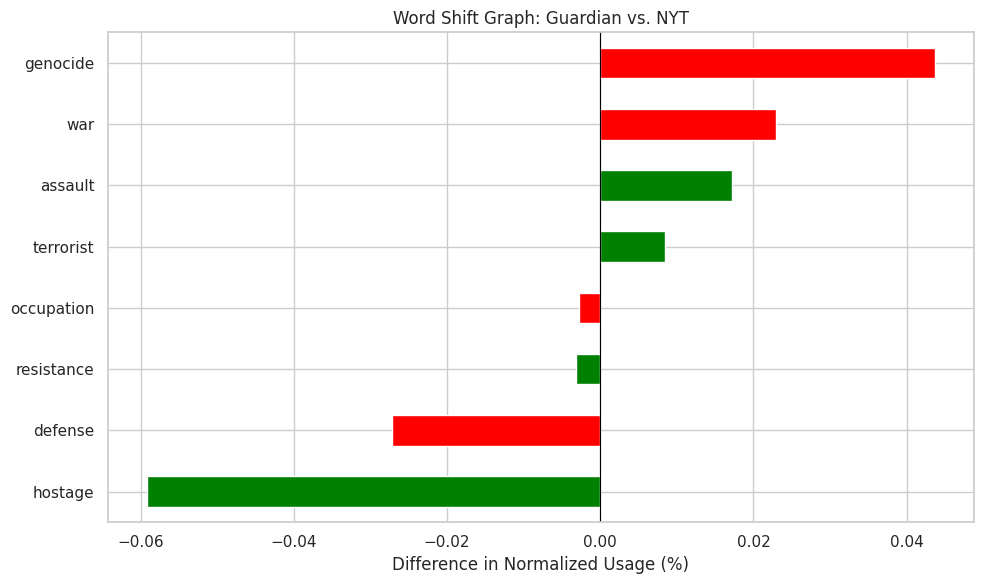

In [ ]:
import numpy as np

# Calculate normalized frequency per outlet
nyt_norm = freq_df['NYT'] / freq_df['NYT'].sum()
guardian_norm = freq_df['Guardian'] / freq_df['Guardian'].sum()

# Compute difference
diff = guardian_norm - nyt_norm

# Plot word shift
diff.sort_values().plot(kind='barh', color=np.where(diff < 0, 'red', 'green'), figsize=(10, 6))
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Word Shift Graph: Guardian vs. NYT')
plt.xlabel('Difference in Normalized Usage (%)')
plt.tight_layout()
plt.show()


In [ ]:
def tag_frame(row):
    headline = row['Headline'].lower()
    if 'hostage' in headline:
        return 'Hostages'
    elif 'humanitarian' in headline or 'aid' in headline:
        return 'Humanitarian Crisis'
    elif 'war' in headline or 'invasion' in headline:
        return 'War/Military Action'
    elif 'ceasefire' in headline:
        return 'Ceasefire/Negotiation'
    else:
        return 'Other'

nyt_df['Frame'] = nyt_df.apply(tag_frame, axis=1)
guardian_df['Frame'] = guardian_df.apply(tag_frame, axis=1)
# Ensure Date column is datetime
nyt_df['Date'] = pd.to_datetime(nyt_df['Date'], errors='coerce')
guardian_df['Date'] = pd.to_datetime(guardian_df['Date'], errors='coerce')

# Add Outlet labels
nyt_df['Outlet'] = 'NYT'
guardian_df['Outlet'] = 'Guardian'

# Combine datasets
combined_df = pd.concat([nyt_df, guardian_df], ignore_index=True)

# Create Month column for grouping
combined_df['Month'] = combined_df['Date'].dt.to_period('M').dt.to_timestamp()  # Monthly bins



<ipython-input-26-eb641295a631>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_df['Month'] = combined_df['Date'].dt.to_period('M').dt.to_timestamp()  # Monthly bins


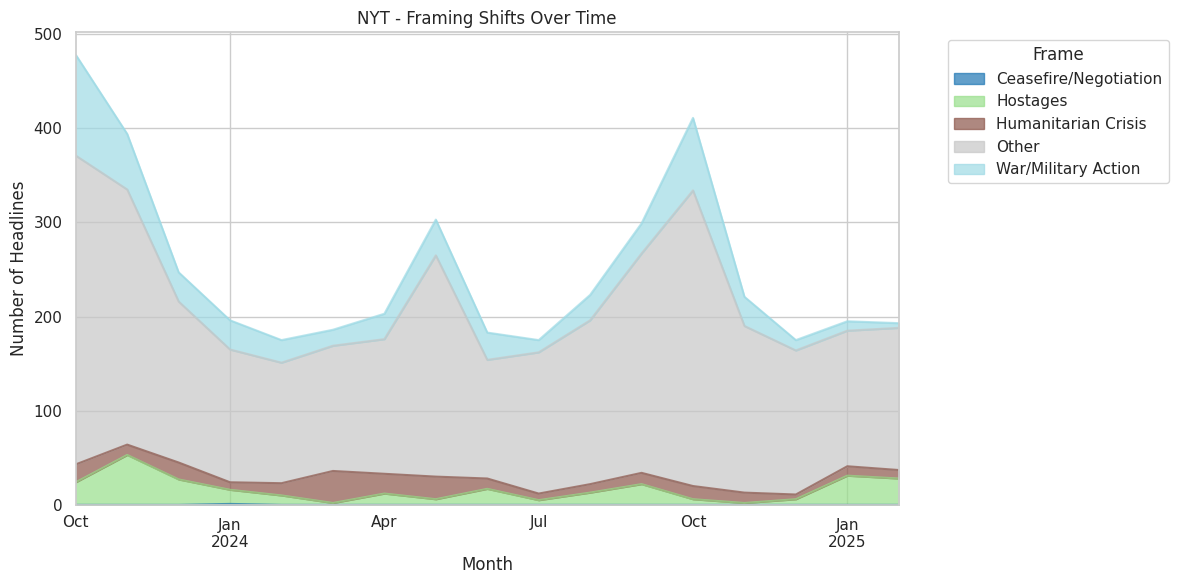

In [ ]:
# Group by Month, Outlet, Frame to count headlines
frame_counts = combined_df.groupby(['Month', 'Outlet', 'Frame']).size().reset_index(name='Count')

# Example output:
# | Month     | Outlet   | Frame                  | Count |
# |-----------|----------|-----------------------|-------|
# | 2023-10-01| NYT      | War/Military Action   | 15    |
# | 2023-10-01| Guardian | Humanitarian Crisis   | 10    |

# Pivot for plotting
frame_pivot = frame_counts.pivot_table(index='Month', columns=['Outlet', 'Frame'], values='Count', fill_value=0)

# Select NYT data only (correct handling of multi-level columns)
nyt_frames = frame_pivot['NYT']

# Stacked area plot
nyt_frames.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7, cmap='tab20')
plt.title('NYT - Framing Shifts Over Time')
plt.ylabel('Number of Headlines')
plt.xlabel('Month')
plt.legend(title='Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


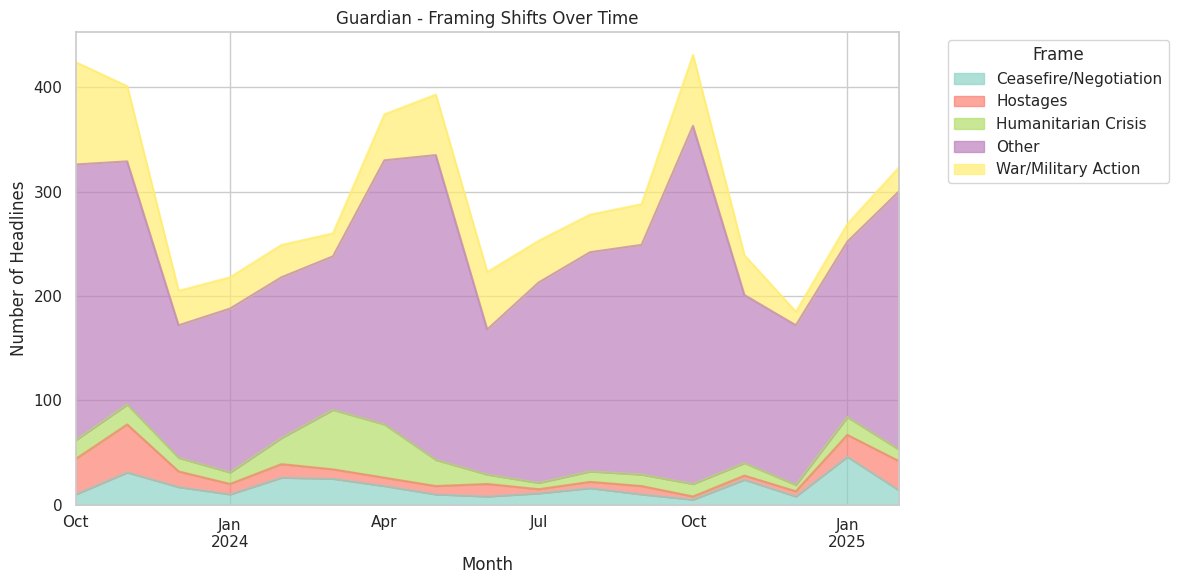

In [ ]:
# Select Guardian data only
guardian_frames = frame_pivot['Guardian']

# Stacked area plot
guardian_frames.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7, cmap='Set3')
plt.title('Guardian - Framing Shifts Over Time')
plt.ylabel('Number of Headlines')
plt.xlabel('Month')
plt.legend(title='Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
def refine_misc(row):
    headline = row['Headline'].lower()
    if 'protest' in headline or 'march' in headline:
        return 'Protests/Activism'
    elif 'united nations' in headline or 'un ' in headline:
        return 'International diplomacy'
    elif 'ceasefire' in headline or 'truce' in headline:
        return 'Ceasefire/Negotiations'
    elif 'opinion' in headline or 'editorial' in headline:
        return 'Media/Opinion'
    elif 'aid' in headline or 'ngo' in headline:
        return 'Humanitarian Aid/NGOs'
    else:
        return 'Other'

df.loc[df['Theme'] == 'Miscellaneous', 'Refined Theme'] = df.loc[df['Theme'] == 'Miscellaneous'].apply(refine_misc, axis=1)


In [ ]:
refined_theme_compare_df.plot(kind='bar', stacked=True, figsize=(14,7), width=0.8, color=['skyblue', 'salmon'])
plt.ylabel('Percentage of Coverage (%)')
plt.title('Refined Thematic Focus: NYT vs Guardian (Israel/Palestine)')
plt.legend(title='Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Sentiment analysis using TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # ranges from -1 (negative) to 1 (positive)

# Apply to both
nyt_df['Sentiment'] = nyt_df['Headline'].apply(get_sentiment)
guardian_df['Sentiment'] = guardian_df['Headline'].apply(get_sentiment)

# Average sentiment per week (optional)
nyt_sentiment_weekly = nyt_df.resample('W', on='Date').mean()['Sentiment'].rename('NYT')
guardian_sentiment_weekly = guardian_df.resample('W', on='Date').mean()['Sentiment'].rename('Guardian')

# Plot sentiment over time
sentiment_df = pd.concat([nyt_sentiment_weekly, guardian_sentiment_weekly], axis=1)

plt.figure(figsize=(12,6))
sentiment_df.plot(marker='o')
plt.title('Sentiment of Israel/Palestine Headlines Over Time')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Date')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Outlet')
plt.show()


TypeError: agg function failed [how->mean,dtype->object]